# 데이터 불러오기, 확인, 전처리
1. 한국어 전처리를 통해 학습 데이터셋을 구축하였다.	

공백과 특수문자 처리, 토크나이징, 병렬데이터 구축의 과정이 적절히 진행되었다.

In [43]:
# 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re

### Data description.

인공데이터입니다. 일부 이별과 관련된 질문에서 다음카페 "사랑보다 아름다운 실연( http://cafe116.daum.net/_c21_/home?grpid=1bld )"에서 자주 나오는 이야기들을 참고하여 제작하였습니다. 

가령 "이별한 지 열흘(또는 100일) 되었어요"라는 질문에 챗봇이 위로한다는 취지로 답변을 작성하였습니다.

챗봇 트레이닝용 문답 페어 11,876개

일상다반사 0, 이별(부정) 1, 사랑(긍정) 2로 레이블링

In [44]:
# 데이터 불러오기
raw_dt = pd.read_csv('ChatbotData .csv')
print(raw_dt.head())
print(raw_dt.info())
print(raw_dt.isnull().sum())
print(raw_dt.label.value_counts())
print(raw_dt[raw_dt.label == 1])

data = raw_dt.copy()

                 Q            A  label
0           12시 땡!   하루가 또 가네요.      0
1      1지망 학교 떨어졌어    위로해 드립니다.      0
2     3박4일 놀러가고 싶다  여행은 언제나 좋죠.      0
3  3박4일 정도 놀러가고 싶다  여행은 언제나 좋죠.      0
4          PPL 심하네   눈살이 찌푸려지죠.      0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB
None
Q        0
A        0
label    0
dtype: int64
label
0    5290
1    3570
2    2963
Name: count, dtype: int64
                         Q                          A  label
5290     1000일 만난 여자친구와 이별         더 오래 만날 사람 만날 거예요.      1
5291       10년 연애. 헤어졌습니다.              더 공허함이 크시겠네요.      1
5292  10년 연애사 되돌아보니 다 부질없네           더 좋은 사람 만나실 거예요.      1
5293              10년 연예의끝               더 마음이 허하겠어요.      1
5294    

In [45]:
# 전처리 함수
def preprocess_sentence(sentence):
  # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거, 영문자가 들어가 있으니 소문자화 시킴
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # 숫자, 영어, 한국어, 구두점 을 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^1-9a-zA-Z가-힣?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

# 테스트 예제
example_sentence = "저는 학생입니다. 여러분은요? AAㅇ    2"
print(preprocess_sentence(example_sentence))

저는 학생입니다 . 여러분은요 ? aa 2


In [46]:
# 전처리 함수 적용, 시리즈를 리스트로 변환 
q_pre = data['Q'].apply(preprocess_sentence).tolist()
a_pre = data['A'].apply(preprocess_sentence).tolist()
print('전체 샘플 수 :', len(q_pre))
print('전체 샘플 수 :', len(a_pre))
print('전처리 후의 22번째 질문 샘플: {}'.format(q_pre[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(a_pre[21]))

전체 샘플 수 : 11823
전체 샘플 수 : 11823
전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 .


In [47]:
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
# 영어가 아니여도 작동함
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(q_pre + a_pre, target_vocab_size=2**13)

# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
# 디코더의 문장 생성 과정에서 사용할 '시작 토큰'과 '종료 토큰'에 대해서도 임의로 단어장에 추가하여서 정수를 부여해 줍니다. 
# 이미 생성된 단어장의 번호와 겹치지 않도록 각각 단어장의 크기와 그보다 1이 큰 수를 번호로 부여
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

START_TOKEN의 번호 : [8158]
END_TOKEN의 번호 : [8159]
8160


In [48]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 25

# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

q_token, a_token = tokenize_and_filter(q_pre, a_pre)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(q_token)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(a_token)))

단어장의 크기 : 8160
필터링 후의 질문 샘플 개수: 11817
필터링 후의 답변 샘플 개수: 11817


In [49]:
# 교사 강요를 통한 병렬 처리
# 질문과 답변의 쌍을 tf.data.Dataset API의 입력으로 사용하여 파이프라인을 구성합니다. 이때, 교사 강요를 위해서 answers[:, :-1]를 디코더의 입력값, answers[:, 1:]를 디코더의 레이블로 사용
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': q_token, # 리스트
        'dec_inputs': a_token[:, :-1] # 리스트
    },
    {
        'outputs': a_token[:, 1:] # 정답 레이블로 쓰임 
    },
))

# cache()는 데이터셋을 메모리에 캐싱하여 I/O 오버헤드를 줄입니다.
# shuffle(BUFFER_SIZE)는 데이터를 섞어서 훈련 중 과적합을 방지합니다.
# batch(BATCH_SIZE)는 데이터를 배치 단위로 묶어줍니다.
# prefetch(tf.data.experimental.AUTOTUNE)는 데이터 로딩과 모델 훈련을 병렬로 수행하여 훈련 속도를 높입니다.
dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [50]:
# 병럴 처리된 데이터셋 구조와 샘플 데이터 확인
for batch in dataset.take(1):
    inputs, outputs = batch
    print("Inputs (inputs):\n", inputs['inputs'].numpy())
    print("Decoder Inputs (dec_inputs):\n", inputs['dec_inputs'].numpy())
    print("Outputs (outputs):\n", outputs['outputs'].numpy())

Inputs (inputs):
 [[8158 2489 2486 ...    0    0    0]
 [8158   88 4427 ...    0    0    0]
 [8158  116    6 ...    0    0    0]
 ...
 [8158  221  948 ...    0    0    0]
 [8158   77 5178 ...    0    0    0]
 [8158  968  599 ...    0    0    0]]
Decoder Inputs (dec_inputs):
 [[8158 6290    1 ...    0    0    0]
 [8158 7414   33 ...    0    0    0]
 [8158 4922  866 ...    0    0    0]
 ...
 [8158  307   82 ...    0    0    0]
 [8158  180 5032 ...    0    0    0]
 [8158   23 7115 ...    0    0    0]]
Outputs (outputs):
 [[6290    1 8159 ...    0    0    0]
 [7414   33 3960 ...    0    0    0]
 [4922  866 1381 ...    0    0    0]
 ...
 [ 307   82  229 ...    0    0    0]
 [ 180 5032 1385 ...    0    0    0]
 [  23 7115 7934 ...    0    0    0]]


2024-06-20 03:13:07.398219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# 모델 구현 & 학습
2. 트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였다.	

구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였다.

In [51]:
# 포지셔널 인코딩 레이어
# sin, cos를 쓰는 이유는 주기성이 다음 장점을 가지기 때문 
# 1. 임베딩 벡터가 커져도 중복되지 않게 값을 부여하기 위함 
# 2. 임베딩 벡터의 상대적인 거리를 표현하기 위함 
# 3. 값들이 크기가 비슷해야 학습이 잘 됨 [-1, 1] 
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    if isinstance(inputs, tf.SparseTensor): # 라이브러리 버전 차이로 인해 추가 - sparseTensor를 denseTensor로 변환
          inputs = tf.sparse.to_dense(inputs) 
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [52]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  # [-1] 는 마지막 차원의 크기를 의미
  depth = tf.cast(tf.shape(key)[-1], tf.float32) # 행렬의 마지막 차원 (depth) 
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9) # 패딩된 위치에 큰 음수로 곱함 -> softmax 함수를 지나면 행렬의 해당 위치가 0에 가까워짐

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

In [53]:
# 멀티 헤드 어텐션
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    # tf.input 은 batch_size를 생략하는게 일반적 -> 정의된 차원보다 입력차원이 크면 맨 앞의 차원을 batch_size로 인식
    # tf.reshape는 batch_size를 생략하지 못함
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth)) # [batch_size, sequence_length, num_heads, depth]
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention) # [batch_size, seq_len_q, d_model], 늘어난 차원을 d_model 차원으로 다시 줄여줍니다

    return outputs


In [54]:
# 패딩 토큰(Padding token) 을 이용한 패딩 마스킹(Padding Masking) - todo 
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # mask의 차원을 확장하여 (batch_size, 1, 1, sequence_length) 형태로 변환, 2번째와 3번째 차원에 1을 추가
  # 확장하는 이유 : 텐션 메커니즘에서 패딩 토큰이 학습에 영향을 미치지 않도록 하기 위해 사용 : 이해 못함 
  return mask[:, tf.newaxis, tf.newaxis, :] # tf.newaxis는 텐서플로에서 새로운 차원을 추가하는 데 사용되는 방법

# 패딩 마스킹이 동작하는지 확인, 0 (패딩)인 단어들은 1로 찾음
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


In [55]:
# 룩 어헤드 마스킹(Look-ahead masking, 다음 단어 가리기)
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1] # 입력 텐서의 크기에서 seq_len을 받아옴 (batch_size, seq_len)
  # tf.linalg.band_part(matrix, num_lower, num_upper)는 대각선 부분 밴드의 값을 유지하고, 나머지 값을 0으로 설정합니다.
  ## num_lower, upper에는 대각선 이후에 유지하고 싶은 대각선의 수를 의미하는 것 같음
  ## -1은 대각선을 포함하는 모든 요소를 유지합니다. 
  ## 0은 대각선만 유지하고, 아래의 모든 요소를 0으로 설정
  # 1-... 을 하면 대각선을 기준으로 위쪽을 0으로 만들고, 아래쪽을 1로 만듭니다.
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x) # 입력 시퀀스의 패딩 토큰(보통 0으로 표현됨)을 마스킹하기 위해 패딩 마스크도 함께 사용
  return tf.maximum(look_ahead_mask, padding_mask) # 두 마스크 중 하나라도 1인 위치를 1로 설정

# 룩 어헤드 마스킹이 동작하는지 확인, 1인 위치는 마스킹된 위치
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

# 패딩 토큰이 존재하는 경우 확인 
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)
tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [56]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [57]:
# 인코더 층을 임베딩 층(Embedding layer) 과 포지셔널 인코딩(Positional Encoding) 을 연결하고, 사용자가 원하는 만큼 인코더 층을 쌓음
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [58]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [59]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [60]:
# 모델 정의 및 학습 
# 앞서 사용한 인코더 층 함수와 디코더 층 함수를 사용하여 트랜스포머 함수를 정의
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs") # 가변 길이의 1차원 정의 (batch_size, sequence_length)
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None), # (batch_size, 1, 1, sequence_length)
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None), # (batch_size, 1, sequence_length, sequence_length)
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [61]:
# 이해함 아마도
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원, 단어 벡터의 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE, # 단어장의 크기
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer) │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_inputs          │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_padding_mask    │ (None, 1, 1,      │          0 │ inputs[0][0]      │
│ (Lambda)            │ None)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ (None, None, 256) │  3,143,168 │ inputs[0][0],     │
│ (Functional)        │                   │            │ enc_padding_mask… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ look_ahead_mask     │ (None, 1, None,   │          0 │ dec_inputs[0][0]  │
│ (Lambda)            │ None)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_padding_mask    │ (None, 1, 1,      │          0 │ inputs[0][0]      │
│ (Lambda)            │ None)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, None, 256) │  3,670,528 │ dec_inputs[0][0], │
│ (Functional)        │                   │            │ encoder[0][0],    │
│                     │                   │            │ look_ahead_mask[… │
│                     │                   │            │ dec_padding_mask… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ outputs (Dense)     │ (None, None,      │  2,097,120 │ decoder[0][0]     │
│                     │ 8160)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,910,816 (33.99 MB)

 Trainable params: 8,910,816 (33.99 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
# 손실 함수
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1)) #?
  
  # from_logit : y_pred가 확률 분포가 아닌 로짓(logit)일 경우 True로 설정
  # reduction='none': 각 샘플별로 손실을 계산합니다. 따라서 배치 내의 각 샘플에 대해 개별 손실 값을 반환
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred) 

  # tf.not_equal(y_true, 0): y_true에서 값이 0이 아닌 위치는 True, 0인 위치는 False로 표시
  # tf.cast(..., tf.float32): True는 1.0으로, False는 0.0으로 변환
  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  # loss와 mask를 곱하여, 실제 레이블이 0인 위치의 손실 값을 0으로 만듭니다. 이는 패딩된 위치의 손실을 무시하기 위함
  loss = tf.multiply(loss, mask)

  # 평균 손실 반환 : 각 샘플의 손실의 평균을 구함
  return tf.reduce_mean(loss)

Text(0.5, 0, 'Train Step')

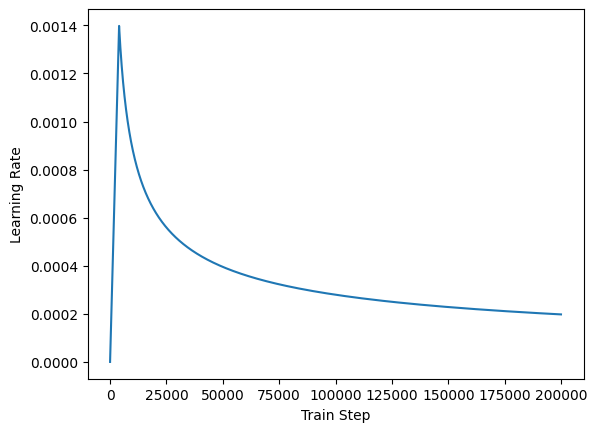

In [63]:
# 커스텀된 학습률 - 이해함
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  # d_model은 모델의 단어 임베딩 차원 수
  # warmup_steps는 학습률이 증가하는 단계의 수
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, tf.float32)  # 추가, 여기서 step을 float32로 변환
    arg1 = tf.math.rsqrt(step) # 현재 학습 단계의 제곱근의 역수를 계산
    arg2 = step * (self.warmup_steps**-1.5) # 현재 학습 단계와 warmup_steps의 -1.5제곱을 곱한 값을 계산

    # 최종 학습률은 d_model의 제곱근의 역수와 arg1과 arg2 중 작은 값을 곱하여 계산됩니다. 이는 초기 학습 단계에서는 학습률이 점진적으로 증가하고, 이후에는 감소하는 형태의 스케줄을 만듭니다
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [64]:
# 모델 컴파일
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# todo 이해 못함
# 예상 y_true : 디코더의 출력 : [단어1, 단어2, 단어3, 단어4, end_token]
# 예상 y_pred : [[단어1의 확률 분포], [단어2의 확률 분포], [단어3의 확률 분포], [단어4의 확률 분포], [end_token의 확률 분포]]
# end_token을 제외하고 정답과 예측의 분포가 일치하는지 확인하는게 좋으므로, reshape을 통해 end_token을 제외하고 shape을 맞춰준거 같음. 여기서 reshape가 어떻게 작동하는지는 모르겠음
# 보통 reshape는 차원의 요소수를 보존한 상태에서 차원을 줄이거나 늘리는데 사용되는데, 여기서는 차원의 요소수를 줄이는데 사용된건가? 이해 안됨 
def accuracy(y_true, y_pred): 
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1)) # 출력의 shape과 맞춤, batch_size, MAX_LENGTH - 1, 디코더의 출력에 end_token이 있으므로 이를 제외
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [65]:
# 훈련 진행 - 이해함 
EPOCHS = 10
model.fit(dataset, epochs=EPOCHS, verbose=1) # verbose 로그의 상세도를 제어, 1 = progress bar, 0 = silent, 2 = one line per epoch

Epoch 1/10


I0000 00:00:1718853195.102911   80910 service.cc:145] XLA service 0x7f86e403e8a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718853195.103027   80910 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-06-20 03:13:15.320936: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1718853195.695261   80910 assert_op.cc:38] Ignoring Assert operator compile_loss/loss_function/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-06-20 03:13:16.062079: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:1718853201.993548   84224 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_21', 456 bytes spill stores, 408 bytes spill loads



  3/185 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.0000e+00 - loss: 2.6476 

I0000 00:00:1718853214.154948   80910 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


179/185 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0204 - loss: 2.4936

W0000 00:00:1718853215.818013   80911 assert_op.cc:38] Ignoring Assert operator compile_loss/loss_function/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1718853221.055759   84814 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_10', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1718853221.066880   84832 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_21', 28 bytes spill stores, 20 bytes spill loads

I0000 00:00:1718853221.282400   84833 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_21', 468 bytes spill stores, 276 bytes spill loads

I0000 00:00:1718853221.315692   84820 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_10', 468 bytes spill stores, 276 bytes spill loads

I0000 00:00:1718853221.325

185/185 ━━━━━━━━━━━━━━━━━━━━ 43s 101ms/step - accuracy: 0.0214 - loss: 2.4889
Epoch 2/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0803 - loss: 2.0103
Epoch 3/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0816 - loss: 1.6690
Epoch 4/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0861 - loss: 1.5149
Epoch 5/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0925 - loss: 1.4254
Epoch 6/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0996 - loss: 1.3298
Epoch 7/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1090 - loss: 1.2112
Epoch 8/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1227 - loss: 1.0941
Epoch 9/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1370 - loss: 0.9787
Epoch 10/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1518 - loss: 0.8290


# 모델 테스트
3. 한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다.	

한국어 입력문장에 맥락에 맞는 한국어로 답변을 리턴하였다.

In [66]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [67]:
# 임의의 입력 문장에 대해서 decoder_inference() 함수를 호출하여 챗봇의 대답을 얻는 sentence_generation() 함수를 만듭
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [71]:
test_sentence = ['좋은 아침입니다.', '공감이 가는 말이네요.', '무슨 생각을 하고 있어요?', '오늘 날씨가 어때요?', '너무 피곤해요.']

for sentence in test_sentence:
    sentence_generation(sentence)
    print('\n')

입력 : 좋은 아침입니다.
출력 : 좋은 생각이에요 .


입력 : 공감이 가는 말이네요.
출력 : 다른 곳에 쓰려고 운을 아껴뒀나봐요 .


입력 : 무슨 생각을 하고 있어요?
출력 : 아직 모르겠어요 .


입력 : 오늘 날씨가 어때요?
출력 : 잘 될 거예요 .


입력 : 너무 피곤해요.
출력 : 좀 더 일찍 주무세요 .


